# Imports

In [1]:
import bs4
from typing import List, TypedDict

from langchain.text_splitter import RecursiveCharacterTextSplitter

# Import Chroma vector store
from langchain.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings
# Import the base Embeddings class from LangChain
from langchain.embeddings.base import Embeddings


from langchain.chat_models import init_chat_model

from langchain_chroma import Chroma


# Load Local GRC Files

In [2]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders.generic import GenericLoader
from langchain_community.document_loaders import FileSystemBlobLoader
from langchain_community.document_loaders.parsers import PyPDFParser
from pathlib import Path
from langchain_huggingface import HuggingFaceEmbeddings

data_path = Path("../../data/test-pdfs")

assert(data_path.is_dir())

loader = GenericLoader(
    blob_loader=FileSystemBlobLoader(
        path=data_path,
        glob="*.pdf",
    ),
    blob_parser=PyPDFParser(),
)

In [3]:
docs = loader.load()
# print(docs)
# print(docs[0].page_content)
# print([f'Document {i}: \n{doc.metadata}\n\n' for i,doc in enumerate(docs,0)])

In [4]:
# Split the documents into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


# Initialize the embeddings using nomic-embed-text

# embeddings = OllamaEmbeddings(model="nomic-embed-text")
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
# Create the Chroma vector store from documents and embeddings
vector_store = Chroma(embedding_function=embeddings)

# Index chunks
document_ids = vector_store.add_documents(documents=all_splits)

C:\Users\Elijah\anaconda3\envs\GRCResponder\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
print(document_ids)

['753e0ecb-aff4-4cb8-8c4a-3ac3a282507f', '3eee743d-c5f6-469e-9a4e-4367e6851c1c', 'aabf37c0-2617-48ea-930a-0956ece13a77', '3f7bd2d8-cdbf-485c-a536-52a80b8dff9d', '5ecb37dc-ff45-45c2-a272-469199c7d120', 'cd38bce0-9372-40ca-a06a-ae76a5fa21fb', '8bbc43c0-3056-4e26-8a99-5b0f01dac9df', 'b7f3d157-3d11-47b1-b46e-5b68ab13292d', 'b1084032-4c44-4a6f-bea1-d41f7aa9521c', '117cda5d-61c6-4d71-bc2f-1d6ffd114efa', '0c97a6ea-1b83-465a-9fd4-7da3d901941d', '4cf817cc-b93e-4734-a68d-62969d3e7c15', '26b31ce2-feae-4bb1-9fdf-9f27fd3954e6', '5004afbf-2d87-4ec0-8991-f9f3f86f1af9', 'db81be04-64cf-421b-add9-666bde1df50a', 'f2e9755a-3636-4e4e-9a7f-1dc1998e4d80', '809a5811-e4f0-422f-a012-f48d30f39235', '02b15c4b-e5e4-4d04-8f86-f698ae05c77e', '2f6318ef-5c89-4a6b-a87c-25949861431f', 'd7728dde-470a-4983-be40-a08e36e4badb', '3bda72bd-cf88-4e61-a33f-0d74614a6301', '52e47ea1-7e7a-476f-9983-e28e8b61b81b', 'ea7e11b2-5556-4d2f-8353-a4318fbd3b72', '062198a1-dceb-4533-baf5-a579b155c709', 'aa5a0d53-8bba-4192-a88f-2a532643cd19',

# Load LLM

In [5]:
llm = init_chat_model("llama3.2:3b-instruct-q8_0", model_provider="ollama")

# RAG

In [16]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

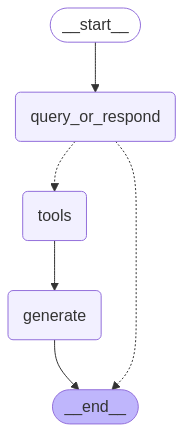

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
from langchain_core.messages.human import HumanMessage
from langchain_core.messages.ai import AIMessage

show_tool_output = False

while True:
    input_message = input()
    if input_message == "exit":
        break

    for step in graph.stream(
        {"messages": [{"role": "user", "content": input_message}]},
        stream_mode="values",
    ):
        if show_tool_output:
            step["messages"][-1].pretty_print()
        else:
            evnt = step["messages"][-1]
            if (type(evnt) == HumanMessage or type(evnt) == AIMessage) and evnt.content != '':
                evnt.pretty_print()

================================ Human Message =================================

Hello, how does RAG work?
================================== Ai Message ==================================

I don't know the details of how RAG works based on the provided context, but I can tell you that RAG (Retrieval-Augmentation-Generation) is a research paradigm that aims to integrate retrieval, augmentation, and generation capabilities into language models. It appears to be a broader concept that encompasses various stages, including "Retrieval", "Generation", and "Augmentation".

The text mentions that the paper compiles and categorizes foundational technical concepts related to RAG methodologies and applications, but it doesn't provide a detailed explanation of how RAG works.

If you need more information on this topic, I suggest checking out additional sources or the original research paper that provides a comprehensive overview of RAG.


KeyboardInterrupt: Interrupted by user

# Show Context

In [34]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    global K
    retrieved_docs = vector_store.similarity_search(query, k=K)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "You are an expert on machine learning"
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know."
        "\n\n"
        f"{docs_content}"
    )

    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    # prompt = conversation_messages
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

In [42]:
from langchain_core.messages.human import HumanMessage
from langchain_core.messages.ai import AIMessage
def main():
    while True:
        input_message = input()
        if input_message == "exit":
            break

        for step in graph.stream(
            {"messages": [{"role": "user", "content": input_message}]},
            stream_mode="values",
        ):
            if show_tool_output:
                step["messages"][-1].pretty_print()
            else:
                evnt = step["messages"][-1]
                if (type(evnt) == HumanMessage or type(evnt) == AIMessage) and evnt.content != '':
                    evnt.pretty_print()

In [51]:
# LLM Model: llama3.2:3b-instruct-q8_0
# Embedding Model: all-MiniLM-L6-v2
K = 5
show_tool_output = True

main()

================================ Human Message =================================

What is RAG?
================================== Ai Message ==================================
Tool Calls:
  retrieve (f218aa38-1c6a-4c72-8b60-2201ac2cd910)
 Call ID: f218aa38-1c6a-4c72-8b60-2201ac2cd910
  Args:
    query: RAG
================================= Tool Message =================================
Name: retrieve

Source: {'author': '', 'creationdate': '2024-03-28T00:54:45+00:00', 'creator': 'LaTeX with hyperref', 'keywords': '', 'moddate': '2024-03-28T00:54:45+00:00', 'page': 0, 'page_label': '1', 'producer': 'pdfTeX-1.40.25', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'source': '..\\..\\data\\test-pdfs\\2312.10997v5.pdf', 'subject': '', 'title': '', 'total_pages': 21, 'trapped': '/False'}
Content: could clarify its broader trajectory. This survey endeavors to
fill this gap by mapping out the RAG process and charting
its evolution a

KeyboardInterrupt: Interrupted by user